In [7]:

import json
import os
import re

import nltk
import numpy as np
import pandas as pd
import spacy
from nltk.corpus import stopwords
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# --------------------------------------------------------------------------
# Wczytanie JSON i ekstrakcja kryteriów
# --------------------------------------------------------------------------

def extract_from_healthnews_json(json_path):
    """
    Wczytuje dane z pliku JSON (lista rekordów lub pojedynczy rekord)
    i zwraca DataFrame z tekstem, ratingiem i 10 kryteriami (Satisfactory = 1, Not = 0).
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    if isinstance(data, dict):
        data = [data]
    
    records = []
    for article in data:
        record = {
            'news_id': article.get('news_id'),
            'title': article.get('title'),
            'text': article.get('text'),
            'rating': article.get('rating'),
        }

        # Ekstrakcja 10 kryteriów
        criteria = article.get('criteria', [])
        for i, crit in enumerate(criteria, start=1):
            answer = crit.get('answer', '').strip()
            if answer.lower().startswith('satisfactory'):
                record[f'C{i}'] = 1
            elif answer.lower().startswith('not'):
                record[f'C{i}'] = 0
            else:
                record[f'C{i}'] = 1  # "Not Applicable" → 1
        
        # Brakujące kryteria uzupełniamy jako Satisfactory
        for j in range(len(criteria) + 1, 11):
            record[f'C{j}'] = 1

        records.append(record)

    return pd.DataFrame(records)

# --------------------------------------------------------------------------
# Wczytanie danych
# --------------------------------------------------------------------------
df = extract_from_healthnews_json("HealthStory_combined.json")

print("="*80)
print("Wczytano dane z JSON")
print(f"Liczba rekordów: {len(df)}")
print(f"Kolumny: {list(df.columns)}")
print("="*80)

# --------------------------------------------------------------------------
# Przygotowanie labels
# --------------------------------------------------------------------------
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['text', 'rating']).reset_index(drop=True)

# Binary label
df['binary_label'] = (df['rating'] >= 3).astype(int)

print("PODSUMOWANIE LABELI")
print(f"RATING: {df['rating'].shape}  (min={df['rating'].min()}, max={df['rating'].max()})")
print(f"BINARY: {df['binary_label'].shape}  → {df['binary_label'].sum()} reliable, {(df['binary_label']==0).sum()} fake")
print("="*80)

# --------------------------------------------------------------------------
# Czyszczenie tekstów
# --------------------------------------------------------------------------
nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^a-z ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_stopwords(text):
    return ' '.join([w for w in text.split() if w not in english_stopwords])

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

print("Czyszczenie tekstów (to może potrwać kilka minut)...")
df['text'] = df['text'].astype(str)
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(lemmatize_text)

# --------------------------------------------------------------------------
# Zapis do pliku
# --------------------------------------------------------------------------
cleaned_path = "HealthStory_cleaned.csv"
df.to_csv(cleaned_path, index=False, encoding='utf-8')

print("="*80)
print(f"Zapisano wszystko do jednego pliku: {cleaned_path}")
print(f" Kolumny: {list(df.columns)}")
print(f" Wiersze: {len(df)}")
print("="*80)


Wczytano dane z JSON
Liczba rekordów: 1638
Kolumny: ['news_id', 'title', 'text', 'rating', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
PODSUMOWANIE LABELI
RATING: (1638,)  (min=0, max=5)
BINARY: (1638,)  → 1178 reliable, 460 fake


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Czyszczenie tekstów (to może potrwać kilka minut)...


KeyboardInterrupt: 

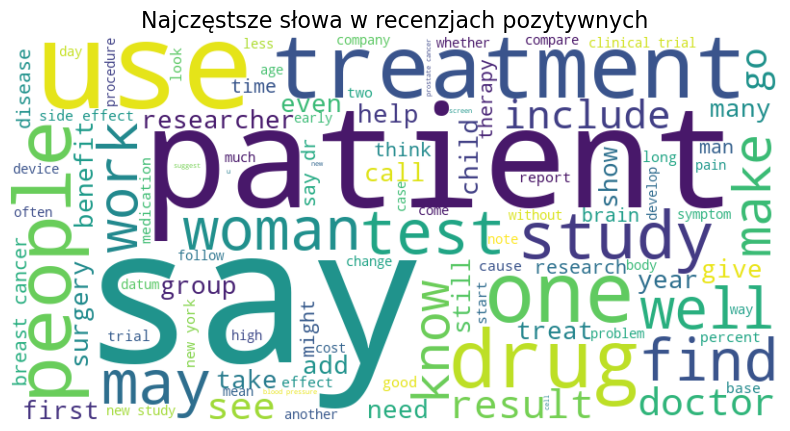

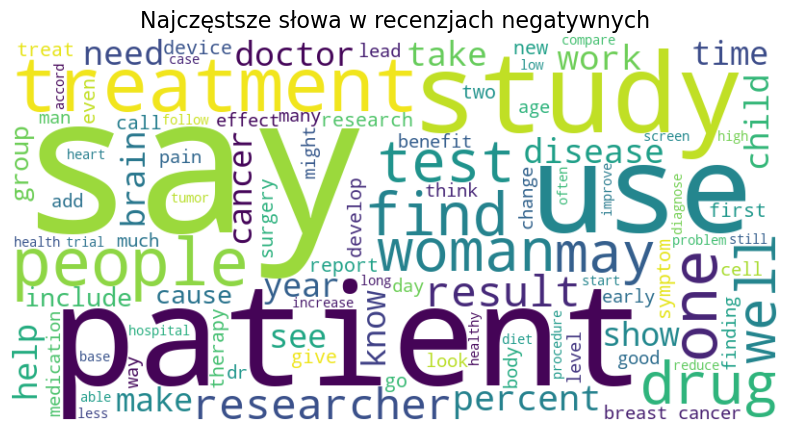

In [8]:
# --- 1a. WordCloud dla wizualizacji najczęstszych słów ---
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_clean = pd.read_csv('HealthStory_cleaned.csv')

# Pozytywne recenzje
positive_text = " ".join(df_clean[df_clean['rating'] >= 3]['text'].astype(str))
# Negatywne recenzje
negative_text = " ".join(df_clean[df_clean['rating'] < 3]['text'].astype(str))

# Funkcja do generowania i wyświetlania wordclouda
def plot_wordcloud(text, title):
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        colormap='viridis'
    ).generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

plot_wordcloud(positive_text, "Najczęstsze słowa w recenzjach pozytywnych")
plot_wordcloud(negative_text, "Najczęstsze słowa w recenzjach negatywnych")


In [11]:
df_clean = pd.read_csv('HealthStory_cleaned.csv')

y = (df_clean['rating'] >= 3).astype(int).values
unique, counts = np.unique(y, return_counts=True)
count_dict = dict(zip(unique, counts))
print("Liczba 0 i 1:", count_dict)


Liczba 0 i 1: {0: 460, 1: 1178}


In [3]:
# --- PARAMETRY ---
EMBEDDING_DIM = 300
FASTTEXT_PATH = 'cc.en.300.vec'

# --- 1. Wczytanie danych ---
df_clean = pd.read_csv('HealthStory_cleaned.csv')

df_clean = df_clean.dropna(subset=['text'])
df_clean = df_clean[df_clean['text'].str.strip() != ""]

texts = df_clean['text'].astype(str).tolist()
y = (df_clean['rating'] >= 3).astype(int).values

# --- 2. Podział train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

print("=" * 60)
print("TRAIN/TEST SPLIT")
print(f"Train: {len(X_train)}  Test: {len(X_test)}")
print("Train label counts:", np.bincount(y_train))
print("Test  label counts:", np.bincount(y_test))
print("=" * 60)

# --- 3. Tokenizacja bez ograniczeń ---
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max(len(seq) for seq in X_train_seq + X_test_seq)
print(f"📏 Maksymalna długość sekwencji w danych: {max_length}")

X_train_seq = pad_sequences(X_train_seq, maxlen=max_length)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_length)

X_train_seq = np.array(X_train_seq, dtype=np.int32)
X_test_seq = np.array(X_test_seq, dtype=np.int32)
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

# --- 4. Embeddingi FastText ---
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

if os.path.exists(FASTTEXT_PATH):
    print("🔹 Wczytywanie FastText embeddings (to może chwilę potrwać)...")
    embedding_index = {}
    with open(FASTTEXT_PATH, 'r', encoding='utf-8', errors='ignore') as f:
        first_line = f.readline().strip().split()
        if len(first_line) != 2 or not all(x.isdigit() for x in first_line):
            f.seek(0)
        for line in f:
            values = line.rstrip().split(' ')
            if len(values) < EMBEDDING_DIM + 1:
                continue
            word = values[0]
            coefs = np.asarray(values[1:EMBEDDING_DIM + 1], dtype='float32')
            embedding_index[word] = coefs

    found = 0
    for word, i in word_index.items():
        if word in embedding_index:
            embedding_matrix[i] = embedding_index[word]
            found += 1
    print(f"✅ Znaleziono embeddingi dla {found:,} / {num_words:,} słów.")
else:
    print("⚠️ Brak pliku FastText — losowa inicjalizacja embeddingów.")
    embedding_matrix = np.random.normal(size=(num_words, EMBEDDING_DIM)).astype('float32')

# --- 5. Model CNN ---
model = Sequential([
    Embedding(
        input_dim=num_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    ),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy']
)

model.summary()

# --- 6. Trening ---
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    epochs=10,
    batch_size=64,
    verbose=1
)

# --- 7. Ewaluacja ---
y_train_pred = (model.predict(X_train_seq) > 0.5).astype(int).ravel()
y_test_pred = (model.predict(X_test_seq) > 0.5).astype(int).ravel()

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred, zero_division=0)
rec_test = recall_score(y_test, y_test_pred, zero_division=0)
f1_test = f1_score(y_test, y_test_pred, zero_division=0)
auc_test = roc_auc_score(y_test, y_test_pred)

print("=" * 60)
print("📊 WYNIKI MODELU CNN")
print(f"Train Accuracy: {acc_train:.4f}")
print(f"Test  Accuracy: {acc_test:.4f}")
print(f"Precision: {prec_test:.4f}")
print(f"Recall:    {rec_test:.4f}")
print(f"F1-Score:  {f1_test:.4f}")
print(f"ROC-AUC:   {auc_test:.4f}")
print("=" * 60)

# --- 8. Zapis modelu ---
model.save("cnn_fasttext_full_unlimited.h5")
print("✅ Model zapisany jako cnn_fasttext_full_unlimited.h5")

# --- 14. Zapisz wyniki do pliku JSON ---
results_summary = {
    'dataset': 'HealthStory',
    'n_samples': len(df_clean),
    'n_features': len(tokenizer.word_index),
    'model': 'CNN + FastText embeddings',
    'metrics': {
        'train': {
            'accuracy': float(acc_train)
        },
        'test': {
            'accuracy': float(acc_test),
            'precision': float(prec_test),
            'recall': float(rec_test),
            'f1': float(f1_test),
            'roc_auc': float(auc_test)
        },
        'history': {
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy']
        }
    },
    'parameters': {
        'embedding_dim': EMBEDDING_DIM,
        'epochs': 10,
        'batch_size': 64,
        'trainable_embeddings': False
    }
}

json_path = 'results_CNN_Embedding.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2)

with open("results_CNN_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
    
print(f"\nWyniki zapisane do: {json_path}")
print("Analiza zakończona pomyślnie!")


TRAIN/TEST SPLIT
Train: 1291  Test: 323
Train label counts: [366 925]
Test  label counts: [ 91 232]
📏 Maksymalna długość sekwencji w danych: 2238
⚠️ Brak pliku FastText — losowa inicjalizacja embeddingów.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2238, 300)         5950500   
                                                                 
 conv1d (Conv1D)             (None, 2234, 128)         192128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)          

In [3]:
# --------------------------------------------------------------------------
# 1. WCZYTANIE DANYCH
# --------------------------------------------------------------------------
df = pd.read_csv("HealthStory_cleaned.csv")
print("Wczytano plik HealthStory_cleaned.csv")
print(f"Liczba rekordów: {len(df)}")
print(f"Kolumny: {list(df.columns)}")

criteria_cols = [f"C{i}" for i in range(1, 11)]
missing_cols = [c for c in criteria_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Brakuje kolumn: {missing_cols}")

# Dane wejściowe i wyjściowe
X_texts = df["text"].astype(str).tolist()
y_criteria = df[criteria_cols].values.astype(int)

# --------------------------------------------------------------------------
# 2. PODZIAŁ NA TRAIN/TEST
# --------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_texts, y_criteria, test_size=0.2, random_state=42
)

print(f"Trening: {len(X_train)} próbek")
print(f"Test: {len(X_test)} próbek")

# --------------------------------------------------------------------------
# 3. TOKENIZACJA BEZ OGRANICZEŃ
# --------------------------------------------------------------------------
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(seq) for seq in tokenizer.texts_to_sequences(X_train))

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post')

# --------------------------------------------------------------------------
# 4. MODEL CNN MULTI-TASK
# --------------------------------------------------------------------------
EMBEDDING_DIM = 300  

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='sigmoid')  # 10 wyjść = 10 kryteriów
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy']
)

model.summary()

# --------------------------------------------------------------------------
# 5. TRENING
# --------------------------------------------------------------------------
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    epochs=10,
    batch_size=64,
    verbose=1
)

# --------------------------------------------------------------------------
# 6. PREDYKCJE
# --------------------------------------------------------------------------
y_pred_test = (model.predict(X_test_seq) > 0.5).astype(int)

# --------------------------------------------------------------------------
# 7. OCENA DLA KAŻDEGO KRYTERIUM
# --------------------------------------------------------------------------
criteria_names = [
    "C1: Koszty interwencji", "C2: Korzyści", "C3: Zagrożenia",
    "C4: Jakość dowodów", "C5: Choroba", "C6: Źródła",
    "C7: Alternatywy", "C8: Dostępność", "C9: Innowacja", "C10: Konflikty"
]

print("\n WYNIKI DLA KAŻDEGO KRYTERIUM:\n")
print(f"{'Kryterium':<45} {'Accuracy':>10} {'F1':>10} {'Recall':>10}")
print("="*80)

results = []
for i, name in enumerate(criteria_names):
    y_true = y_test[:, i]
    y_pred = y_pred_test[:, i]

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    prec = precision_score(y_true, y_pred, zero_division=0)

    results.append((acc, f1, rec))
    print(f"{name:<45} {acc:>10.4f} {f1:>10.4f} {rec:>10.4f}")

# --------------------------------------------------------------------------
# 8. ŚREDNIE WYNIKI
# --------------------------------------------------------------------------
avg_acc = np.mean([r[0] for r in results])
avg_f1 = np.mean([r[1] for r in results])
avg_rec = np.mean([r[2] for r in results])

print("="*80)
print(f"{'ŚREDNIA (wszystkie kryteria)':<45} {avg_acc:>10.4f} {avg_f1:>10.4f} {avg_rec:>10.4f}")
print("="*80)

# --------------------------------------------------------------------------
# 9. Zapis wyników do pliku JSON
# --------------------------------------------------------------------------
results_summary = {
    'dataset': 'HealthStory',
    'n_samples': len(df),
    'vocab_size': len(tokenizer.word_index),
    'model': 'CNN Multi-Output',
    'parameters': {
        'embedding_dim': EMBEDDING_DIM,
        'epochs': 10,
        'batch_size': 64
    },
    'metrics_per_criterion': [],
    'average_metrics': {
        'accuracy': float(avg_acc),
        'f1': float(avg_f1),
        'recall': float(avg_rec)
    }
}

for i, name in enumerate(criteria_names):
    results_summary['metrics_per_criterion'].append({
        'criterion': name,
        'accuracy': float(results[i][0]),
        'f1': float(results[i][1]),
        'recall': float(results[i][2])
    })

with open('results_CNN_MultiOutput.json', 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2)

print("\nWyniki zapisane do: results_CNN_MultiOutput.json")

# --------------------------------------------------------------------------
# 10. ZAPIS MODELU I TOKENIZERA
# --------------------------------------------------------------------------

# Zapis modelu Keras
model.save("CNN_MultiOutput_model.h5")
print("Model zapisany do: CNN_MultiOutput_model.h5")

# Zapis tokenizer
with open("tokenizer_MultiOutput.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("Tokenizer zapisany do: tokenizer.pkl")



NameError: name 'pd' is not defined

In [9]:
from keras.layers import Bidirectional
from keras.layers import LSTM

# --- PARAMETRY ---
EMBEDDING_DIM = 300
FASTTEXT_PATH = 'cc.en.300.vec'

# --- 1. Wczytanie danych ---
df_clean = pd.read_csv('HealthStory_cleaned.csv')

df_clean = df_clean.dropna(subset=['text'])
df_clean = df_clean[df_clean['text'].str.strip() != ""]

texts = df_clean['text'].astype(str).tolist()
y = (df_clean['rating'] >= 3).astype(int).values

# --- 2. Podział train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

print("=" * 60)
print("TRAIN/TEST SPLIT")
print(f"Train: {len(X_train)}  Test: {len(X_test)}")
print("Train label counts:", np.bincount(y_train))
print("Test  label counts:", np.bincount(y_test))
print("=" * 60)

# --- 3. Tokenizacja bez ograniczeń ---
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max(len(seq) for seq in X_train_seq + X_test_seq)
print(f"📏 Maksymalna długość sekwencji w danych: {max_length}")

X_train_seq = pad_sequences(X_train_seq, maxlen=max_length)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_length)

X_train_seq = np.array(X_train_seq, dtype=np.int32)
X_test_seq = np.array(X_test_seq, dtype=np.int32)
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

# --- 4. Embeddingi FastText ---
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

if os.path.exists(FASTTEXT_PATH):
    print("🔹 Wczytywanie FastText embeddings (to może chwilę potrwać)...")
    embedding_index = {}
    with open(FASTTEXT_PATH, 'r', encoding='utf-8', errors='ignore') as f:
        first_line = f.readline().strip().split()
        if len(first_line) != 2 or not all(x.isdigit() for x in first_line):
            f.seek(0)
        for line in f:
            values = line.rstrip().split(' ')
            if len(values) < EMBEDDING_DIM + 1:
                continue
            word = values[0]
            coefs = np.asarray(values[1:EMBEDDING_DIM + 1], dtype='float32')
            embedding_index[word] = coefs

    found = 0
    for word, i in word_index.items():
        if word in embedding_index:
            embedding_matrix[i] = embedding_index[word]
            found += 1
    print(f"✅ Znaleziono embeddingi dla {found:,} / {num_words:,} słów.")
else:
    print("⚠️ Brak pliku FastText — losowa inicjalizacja embeddingów.")
    embedding_matrix = np.random.normal(size=(num_words, EMBEDDING_DIM)).astype('float32')

# --- 5. Model LSTM ---
model = Sequential([
    Embedding(
        input_dim=num_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    ),
    Bidirectional(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy']
)

model.summary()

# --- 6. Trening ---
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    epochs=10,
    batch_size=64,
    verbose=1
)

# --- 7. Ewaluacja ---
y_train_pred = (model.predict(X_train_seq) > 0.5).astype(int).ravel()
y_test_pred = (model.predict(X_test_seq) > 0.5).astype(int).ravel()

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred, zero_division=0)
rec_test = recall_score(y_test, y_test_pred, zero_division=0)
f1_test = f1_score(y_test, y_test_pred, zero_division=0)
auc_test = roc_auc_score(y_test, y_test_pred)

print("=" * 60)
print("📊 WYNIKI MODELU LSTM")
print(f"Train Accuracy: {acc_train:.4f}")
print(f"Test  Accuracy: {acc_test:.4f}")
print(f"Precision: {prec_test:.4f}")
print(f"Recall:    {rec_test:.4f}")
print(f"F1-Score:  {f1_test:.4f}")
print(f"ROC-AUC:   {auc_test:.4f}")
print("=" * 60)

# --- 8. Zapis modelu ---
model.save("lstm_fasttext_full_unlimited.h5")
print("✅ Model zapisany jako lstm_fasttext_full_unlimited.h5")

# --- 14. Zapisz wyniki do pliku JSON ---
results_summary = {
    'dataset': 'HealthStory',
    'n_samples': len(df_clean),
    'n_features': len(tokenizer.word_index),
    'model': 'BiLSTM + FastText embeddings',
    'metrics': {
        'train': {
            'accuracy': float(acc_train)
        },
        'test': {
            'accuracy': float(acc_test),
            'precision': float(prec_test),
            'recall': float(rec_test),
            'f1': float(f1_test),
            'roc_auc': float(auc_test)
        },
        'history': {
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy']
        }
    },
    'parameters': {
        'embedding_dim': EMBEDDING_DIM,
        'epochs': 10,
        'batch_size': 64,
        'trainable_embeddings': False,
        'lstm_units': 128,
        'bidirectional': True
    }
}

json_path = 'results_LSTM_Embedding.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2)

with open("results_LSTM_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
    
print(f"\nWyniki zapisane do: {json_path}")
print("Analiza zakończona pomyślnie!")


TRAIN/TEST SPLIT
Train: 1291  Test: 323
Train label counts: [366 925]
Test  label counts: [ 91 232]
📏 Maksymalna długość sekwencji w danych: 2238
⚠️ Brak pliku FastText — losowa inicjalizacja embeddingów.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2238, 300)         5950500   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)           

KeyboardInterrupt: 